In [5]:
%pylab inline

%pylab is deprecated, use %matplotlib inline and import the required libraries.
Populating the interactive namespace from numpy and matplotlib


In [6]:
1/2 * 32768

16384.0

In [7]:
wavelen = 10000
x = arange(wavelen)
gradRising = 10
gradRisingInv = int((1/gradRising) * 32768)
triPeakPoint = (wavelen * gradRisingInv) >> 15
gradFalling = ((1/(1 - (1/gradRising))))
gradRising = int(gradRising * 32768)
gradFalling = int(gradFalling * 32768)
[gradRising, gradFalling, gradRisingInv, triPeakPoint]

[327680, 36408, 3276, 999]

In [8]:
y = zeros_like(x)
for i in range(len(x)):
    v = x[i]
    if (i < triPeakPoint):
        v = (v * gradRising) >> 15
    else:
        v = wavelen - (int((v-triPeakPoint) * gradFalling) >> 15)
    y[i] = v
    

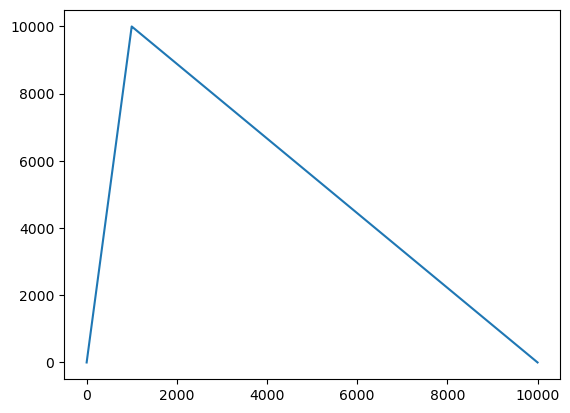

In [9]:
plot(y)

In [10]:
mul = int(0.7*256)
print(mul)

1000 * mul >> 8

179


699

In [11]:
#bit expts

#err manipulation

#aim - want nonlinear reaction to frequency, possible long term effects using feedback going beyond wavelenth

In [12]:
y=0
err=0
phase=0
sr = 1_000_000
wavelen = int(sr / 300)
cycles = 40


gradRising = 2
gradRisingInv = int((1/gradRising) * 32768)
triPeakPoint = (wavelen * gradRisingInv) >> 15
gradFalling = ((1/(1 - (1/gradRising))))
gradRising = int(gradRising * 32768)
gradFalling = int(gradFalling * 32768)
print([gradRising, gradFalling, gradRisingInv, triPeakPoint, wavelen])

bs = np.zeros(cycles * wavelen, dtype=uint8)
lasterr=0
a=0.005
b=1-a
yz1=0
yz2=0
yz=0
err2=0
err3=0
for i in range(len(bs)):
    #phase
    phase = phase + 1
    if (phase >= wavelen):
        phase=0
    #tri
    # amp=phase * 2 if phase < triPeakPoint else wavelen - ((phase-triPeakPoint) * 2) 
    
    #tri2
    # triPeakPoint = wavelen // 4
    # amp=phase * 4 if phase < triPeakPoint else wavelen - ((phase-triPeakPoint) * 4) 
    # if (amp < 0): amp=0

    # amp = 0 if phase < wavelen // 2 else wavelen

    amp = phase
    
    # if (phase < triPeakPoint):
    #     amp = (amp * gradRising) >> 15
    # else:
    #     amp = wavelen - (int((amp-triPeakPoint) * gradFalling) >> 15)

    # # tri var 2
    # if (phase < triPeakPoint):
    #     amp = (amp * gradRising) >> 15
    # else:
    #     amp = wavelen - (int((amp-triPeakPoint) * gradFalling) >> 15)

    # y = 1 if amp >= err else 0

    # yy=y
    # if (phase >= triPeakPoint):
    #     yy = ~yy

    # err = ((wavelen) if y | yz1 | yz2  else 0) - amp + err
    # yz2=yz1
    # yz1 = y

    # yz = yz << 1
    # yz = yz | y
    # err = ((wavelen) if ((yz & 0b11100101) > 0)   else 0) - amp + err
    
    y = 1 if amp >= err2+err else 0
    err = ((wavelen) if y else 0) - amp + err - err2
    err2 = err2 + (err * 0.8)
    
    # err2 = ((wavelen) if y else 0) - amp + err2
    # err3 = ((wavelen) if y else 0) - amp + err3
    # err = err * 0.9
    # err = err + (wavelen*0.5)
    # err = err - (wavelen*0.1)
    # err = err - (wavelen*0.4)
    # err2 = err2 - ( 0.2 * err)
    # err3 = err3 - ( 0.01 * err)
    # err3 = err2 - ( -0.02 * err2)
    # err = err + err2 + err3    
    # err = ((wavelen<<0) if y else ((wavelen * wavelen) >> 14)) - (amp * 0.9) + err
    # err = ((wavelen<<1) if y else -(wavelen>>2)) - amp + err
    # err = ((wavelen) if y else (-wavelen*2)) - amp + err
    # err = int((err * a) + (lasterr*b))
    # err = pow(err,0.9)
    # if (phase > wavelen/2):
        # err = max(0,err - (wavelen >> 2))
    lasterr = err
    bs[i] = int(y)

[65536, 65536, 16384, 1666, 3333]


In [13]:
(1 << 14) * 0.0001

1.6384

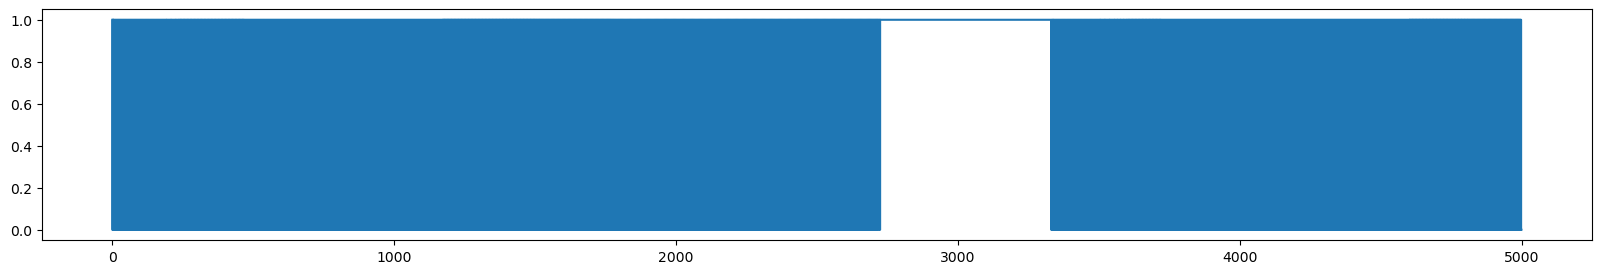

In [14]:
figsize(20,3)
windowLen = 5000
step(arange(windowLen),bs[:windowLen])

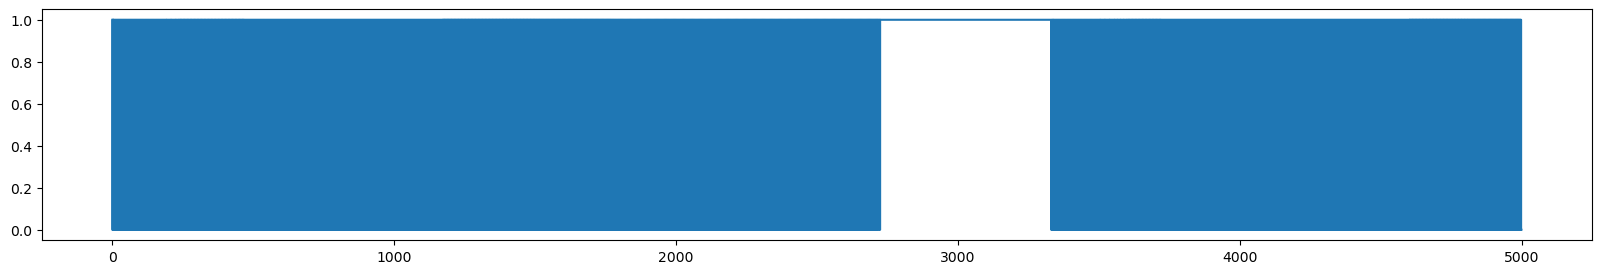

In [15]:
def pack32(bits):
    v=0
    idx=len(bits)-1
    for bit in bits:
        v = v | (bit << idx)
        idx = idx - 1
    return v

pack32(bs[:32])

#bit processing
#pack stream into 32 bit words
numWords = len(bs)//32
bs32 = zeros(numWords, dtype=uint32)
for i in range(numWords):
    # bs32[i] = pack32(bs[i*32:(i+1)*32])
    bs32[i] = pack32(bs[i*32:(i+1)*32])



#bit processing

bs32Processed = zeros_like(bs32)
for i in range(numWords-2):
    # bs32Processed[i] = (bs32[i] | 0b1010101010001000_10101000_10101000)
    bs32Processed[i] = bs32[i] 
    # bs32Processed[i] = bs32[i] << (i % 31) #get shift from wavetable over n*wavelen
    # bs32Processed[i] = bs32[i] << (i % 31)
    # bs32Processed[i] = bs32[i]



#unpack
bsunpack = zeros_like(bs)
idx=0
for i in range(numWords):
    for j in range(32):
        bsunpack[idx] = (bs32Processed[i] >> (31-j)) & 1
        idx = idx + 1   
        

step(arange(windowLen),bsunpack[:windowLen])

In [16]:
1000 * 2991>> 18

11

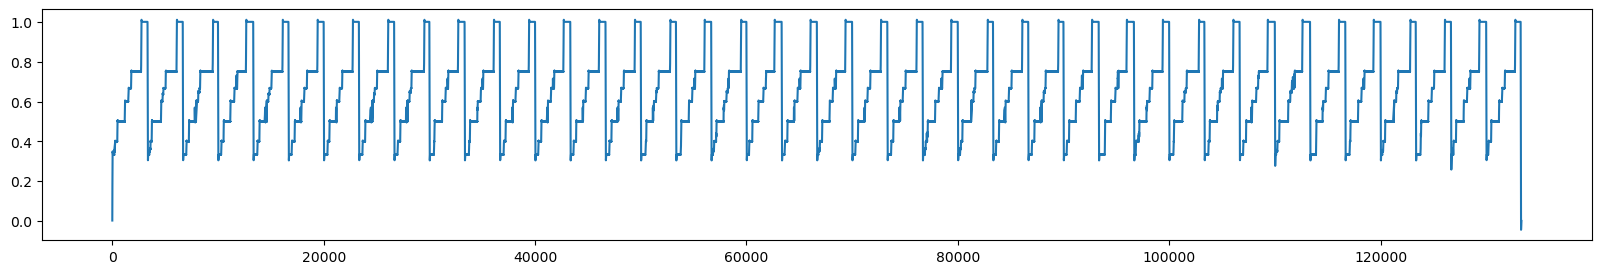

In [17]:
from scipy import signal
sos = signal.butter(2, 18000, 'lp', fs=sr, output='sos')
filtered = signal.sosfilt(sos, bsunpack)
plot(filtered)

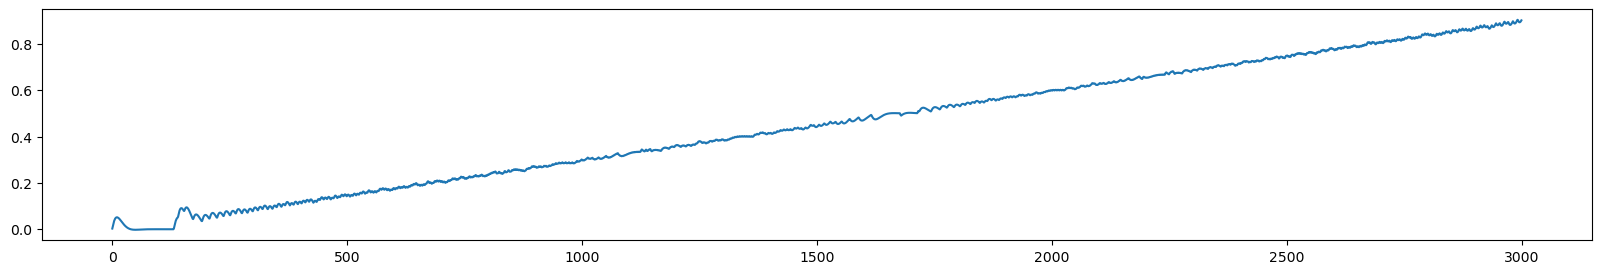

In [339]:
plot(filtered[:3000])

In [340]:
wav = np.tile(librosa.resample(filtered, orig_sr=sr, target_sr=44100),100)
Audio(wav, rate=44100)

In [284]:
import librosa
from IPython.display import Audio

In [262]:
np.tile([1,2,3,4],10)

array([1, 2, 3, 4, 1, 2, 3, 4, 1, 2, 3, 4, 1, 2, 3, 4, 1, 2, 3, 4, 1, 2,
       3, 4, 1, 2, 3, 4, 1, 2, 3, 4, 1, 2, 3, 4, 1, 2, 3, 4])

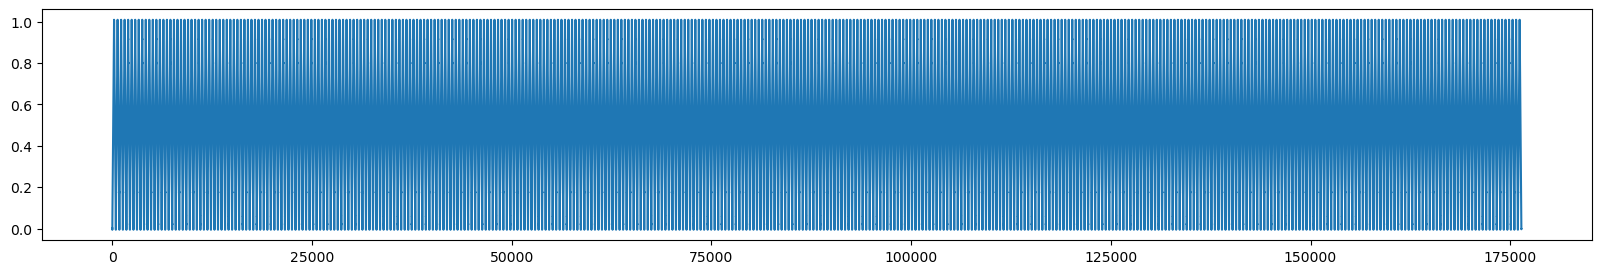

In [325]:

plot(wav)

In [66]:
120003 << 20

125832265728

In [110]:
bs32Processed[100]

3680501760

In [118]:
(bs32[100] << 20) & (pow(2,32) - 1)

3680501760

In [120]:
bs32[100] << 20

1889900959891456

In [338]:
qfp=15

In [339]:
qfpmul=1<<qfp

In [340]:
15*2.4

36.0

In [342]:
bfp = int(2.4*qfpmul)
[bfp]

[78643]

In [345]:
res = 15 * bfp
res

1179645

In [346]:
res >> qfp

35